# 1. Data

## 1.1 Data Processing

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Read the original dataset
df = pd.read_csv('hotel_bookings.csv')

# Drop irrelevant columns
irrelevant_columns = [
    'reservation_status', 'reservation_status_date', 'agent', 'company', 'reservation_id'
]
for col in irrelevant_columns:
    if col in df.columns:
        df = df.drop(columns=col)

# Remove all rows with any missing values
df = df.dropna()

# Cap outliers at the 99th percentile for selected columns
for col in ['lead_time', 'booking_changes']:
    if col in df.columns:
        upper = df[col].quantile(0.99)
        df[col] = np.where(df[col] > upper, upper, df[col])

# Select relevant variables
selected_columns = [
    'is_canceled',
    'lead_time',
    'distribution_channel',
    'deposit_type',
    'market_segment',
    'stays_in_weekend_nights',
    'stays_in_week_nights',
    'country',
    'is_repeated_guest',
    'reserved_room_type',
    'assigned_room_type',
    'booking_changes',
    'adults',
    'children',
    'babies',
    'meal',
    'total_of_special_requests',
    'required_car_parking_spaces'
]
df = df[[col for col in selected_columns if col in df.columns]]

# One-hot encode categorical variables
categorical_cols = [
    'distribution_channel', 'deposit_type', 'market_segment', 'country',
    'reserved_room_type', 'assigned_room_type', 'meal'
]
df = pd.get_dummies(df, columns=[col for col in categorical_cols if col in df.columns], drop_first=True)

# Standardize numerical variables (excluding the target variable)
scaler = StandardScaler()
numeric_cols = [
    'lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights',
    'adults', 'children', 'babies', 'booking_changes', 'total_of_special_requests'
]
numeric_cols = [col for col in numeric_cols if col in df.columns]
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# Split into features (X) and target (y)
X = df.drop('is_canceled', axis=1)
y = df['is_canceled']

# Split data into train and test sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(y.value_counts())
print(df.head())

is_canceled
0    74745
1    44153
Name: count, dtype: int64
   is_canceled  lead_time  stays_in_weekend_nights  stays_in_week_nights  \
0            0   2.277402                -0.932429             -1.316808   
1            0   3.252230                -0.932429             -1.316808   
2            0  -0.924239                -0.932429             -0.790536   
3            0  -0.866897                -0.932429             -0.790536   
4            0  -0.857339                -0.932429             -0.264264   

   is_repeated_guest  booking_changes    adults  children    babies  \
0                  0         5.023963  0.244755 -0.261059 -0.081618   
1                  0         5.023963  0.244755 -0.261059 -0.081618   
2                  0        -0.377357 -1.483635 -0.261059 -0.081618   
3                  0        -0.377357 -1.483635 -0.261059 -0.081618   
4                  0        -0.377357  0.244755 -0.261059 -0.081618   

   total_of_special_requests  ...  assigned_room_type_G 

# 2. Logistic Regression

## 2.1 Logistic Regression Modeling & Evaluation

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# Train a logistic regression model
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train, y_train)

# Predict on test set
y_pred = logreg.predict(X_test)
y_prob = logreg.predict_proba(X_test)[:, 1]

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, y_prob)
print(f"ROC AUC Score: {roc_auc:.4f}")


Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.91      0.86     22424
           1       0.80      0.64      0.71     13246

    accuracy                           0.81     35670
   macro avg       0.81      0.77      0.79     35670
weighted avg       0.81      0.81      0.80     35670

ROC AUC Score: 0.8894


## 2.2 Visualization for Logistic Regression

<Figure size 600x500 with 0 Axes>

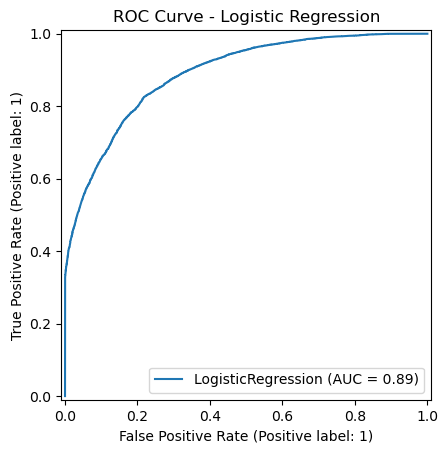

Confusion Matrix:
[[20354  2070]
 [ 4743  8503]]


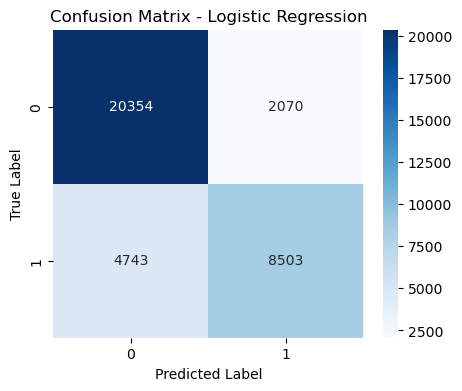

In [3]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

# Plot ROC curve
plt.figure(figsize=(6, 5))
RocCurveDisplay.from_estimator(logreg, X_test, y_test)
plt.title("ROC Curve - Logistic Regression")
plt.show()

# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Plot confusion matrix as heatmap
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()


## 2.3 Display Feature Coefficients of Logistic Regression

Top 15 most influential features (by absolute coefficient):
                         Feature  Coefficient
9    required_car_parking_spaces    -6.061760
14       deposit_type_Non Refund     5.002060
214         assigned_room_type_I    -4.580664
212         assigned_room_type_G    -3.136679
26                   country_ARE     2.870411
203         reserved_room_type_G     2.769166
215         assigned_room_type_K    -2.735852
211         assigned_room_type_F    -2.645078
201         reserved_room_type_E     2.294587
202         reserved_room_type_F     2.239869
210         assigned_room_type_E    -2.138708
90                   country_HKG     1.884118
170                  country_SRB    -1.740883
84                   country_GIB     1.718582
147                  country_NZL    -1.701144


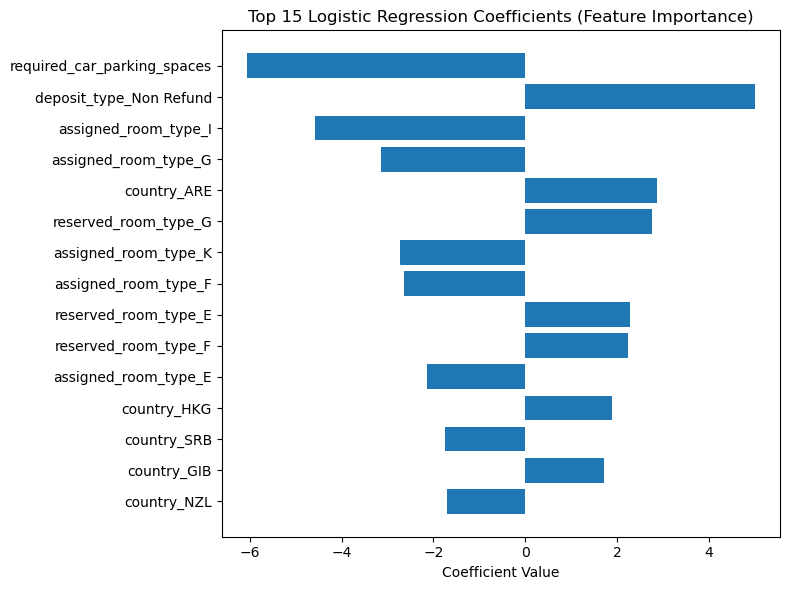

In [4]:
import matplotlib.pyplot as plt

# Get feature names after one-hot encoding
feature_names = X_train.columns

# Get coefficients from the trained Logistic regression model
coefficients = logreg.coef_[0]

# Combine into DataFrame
logreg_feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Sort by absolute value of coefficient (importance)
logreg_feature_importance['abs_coef'] = logreg_feature_importance['Coefficient'].abs()
logreg_feature_importance = logreg_feature_importance.sort_values(by='abs_coef', ascending=False).drop('abs_coef', axis=1)

# Show top 15
print("Top 15 most influential features (by absolute coefficient):")
print(logreg_feature_importance.head(15))

# Plot
plt.figure(figsize=(8, 6))
plt.barh(logreg_feature_importance['Feature'].head(15), logreg_feature_importance['Coefficient'].head(15))
plt.xlabel('Coefficient Value')
plt.title('Top 15 Logistic Regression Coefficients (Feature Importance)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# 3. Random Forest 

## 3.1 Modeling & Evaluation

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Train Random Forest model
rf = RandomForestClassifier(
    n_estimators=100,    # Number of trees
    max_depth=None,      
    random_state=42,
    n_jobs=-1            
)
rf.fit(X_train, y_train)

# Predict on test set
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

# Print classification report
print("Classification Report (Random Forest):")
print(classification_report(y_test, y_pred_rf))

# Calculate ROC AUC score
roc_auc_rf = roc_auc_score(y_test, y_proba_rf)
print(f"ROC AUC Score (Random Forest): {roc_auc_rf:.4f}")

Classification Report (Random Forest):
              precision    recall  f1-score   support

           0       0.87      0.91      0.89     22424
           1       0.83      0.77      0.80     13246

    accuracy                           0.86     35670
   macro avg       0.85      0.84      0.84     35670
weighted avg       0.86      0.86      0.86     35670

ROC AUC Score (Random Forest): 0.9278


## 3.2  Visualization for Random Forest

<Figure size 600x500 with 0 Axes>

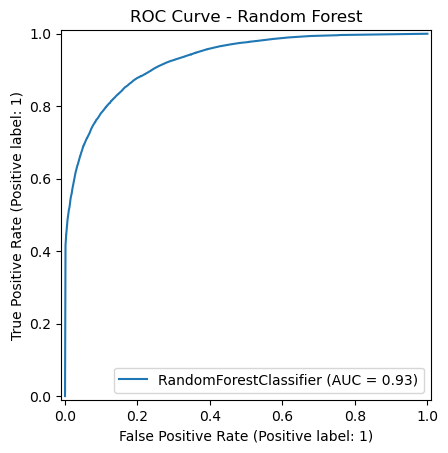

Confusion Matrix:
[[20394  2030]
 [ 3086 10160]]


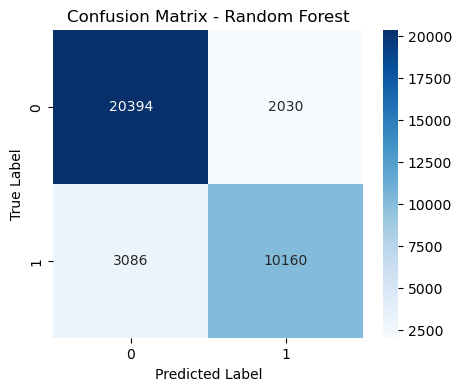

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import RocCurveDisplay, confusion_matrix

# Plot ROC curve using from_estimator (recommended for sklearn >= 1.0)
plt.figure(figsize=(6, 5))
RocCurveDisplay.from_estimator(rf, X_test, y_test)
plt.title("ROC Curve - Random Forest")
plt.show()

# Print confusion matrix values
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

# Plot confusion matrix as heatmap
cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Random Forest")
plt.show()


## 3.3 Display Feature Importances of Random Forest

Top 15 most important features in Random Forest:
                          Feature  Importance
0                       lead_time    0.283669
14        deposit_type_Non Refund    0.083997
156                   country_PRT    0.081566
8       total_of_special_requests    0.072858
2            stays_in_week_nights    0.069814
1         stays_in_weekend_nights    0.040309
4                 booking_changes    0.031236
21       market_segment_Online TA    0.027622
9     required_car_parking_spaces    0.024786
5                          adults    0.023359
19          market_segment_Groups    0.021229
20   market_segment_Offline TA/TO    0.018554
209          assigned_room_type_D    0.017261
12     distribution_channel_TA/TO    0.014280
219                       meal_HB    0.010861


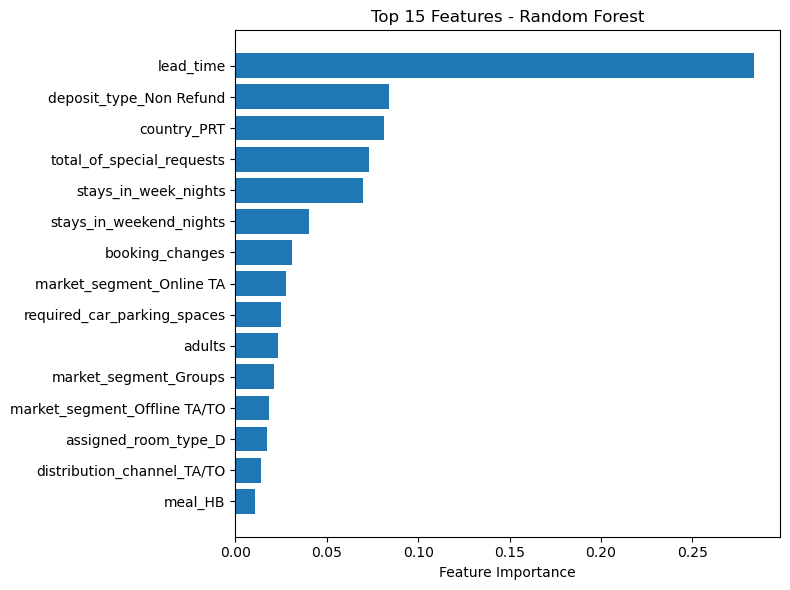

In [10]:
import matplotlib.pyplot as plt

# Get feature importances
importances = rf.feature_importances_
feature_names = X_train.columns

# Combine into DataFrame
rf_feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
rf_feature_importance = rf_feature_importance.sort_values(by='Importance', ascending=False)

# Show top 15
print("Top 15 most important features in Random Forest:")
print(rf_feature_importance.head(15))

# Plot
plt.figure(figsize=(8, 6))
plt.barh(rf_feature_importance['Feature'].head(15), rf_feature_importance['Importance'].head(15))
plt.xlabel('Feature Importance')
plt.title('Top 15 Features - Random Forest')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# 4. Support Vector Machine (SVM)

## 4.1 SVM Modeling & Evaluation

In [11]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# Model Training and Prediction: SVM
svm_clf = SVC(kernel='rbf', probability=True, random_state=42)
svm_clf.fit(X_train, y_train)

# Predict labels and predicted probabilities
y_pred_svm = svm_clf.predict(X_test)
y_prob_svm = svm_clf.predict_proba(X_test)[:, 1]

# Model Evaluation: SVM
print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm))

print("SVM Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_svm))

roc_auc_svm = roc_auc_score(y_test, y_prob_svm)
print(f"SVM ROC-AUC Score: {roc_auc_svm:.4f}")

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.91      0.88     22424
           1       0.83      0.72      0.77     13246

    accuracy                           0.84     35670
   macro avg       0.83      0.81      0.82     35670
weighted avg       0.84      0.84      0.84     35670

SVM Confusion Matrix:
[[20409  2015]
 [ 3746  9500]]
SVM ROC-AUC Score: 0.9119


## 4.2 Visualization for SVM

<Figure size 600x500 with 0 Axes>

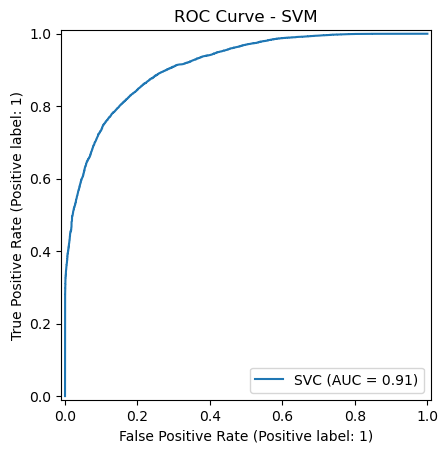

Confusion Matrix:
[[20409  2015]
 [ 3746  9500]]


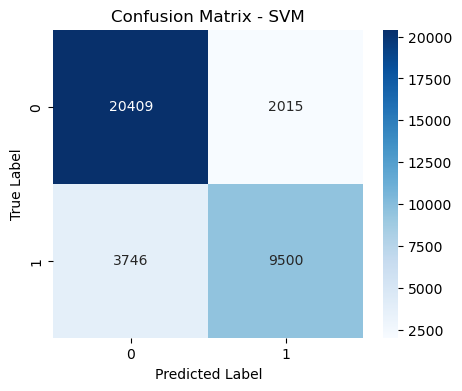

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import RocCurveDisplay, confusion_matrix

# Plot ROC curve using from_estimator
plt.figure(figsize=(6, 5))
RocCurveDisplay.from_estimator(svm_clf, X_test, y_test)
plt.title("ROC Curve - SVM")
plt.show()

# Print confusion matrix values
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_svm))

# Plot confusion matrix as heatmap
cm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - SVM")
plt.show()


# 5. Extreme Gradient Boosting (XGBoost)

## 5.1 Modeling & Evaluation

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.89      0.88     22424
           1       0.81      0.77      0.79     13246

    accuracy                           0.85     35670
   macro avg       0.84      0.83      0.83     35670
weighted avg       0.85      0.85      0.85     35670

XGBoost Confusion Matrix:
[[20056  2368]
 [ 3112 10134]]
XGBoost ROC-AUC Score: 0.9260


<Figure size 1000x600 with 0 Axes>

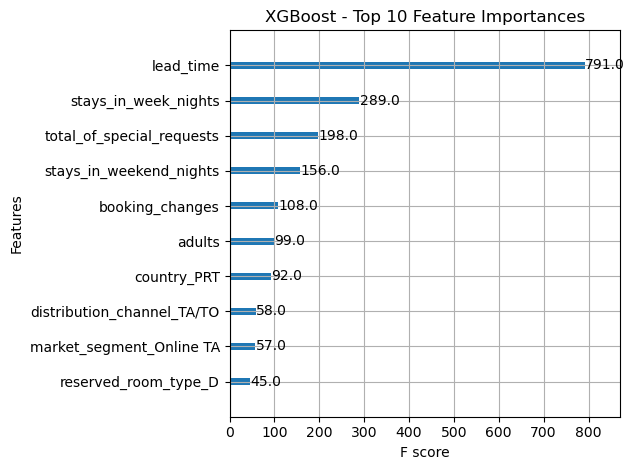

In [16]:
from xgboost import XGBClassifier, plot_importance
import matplotlib.pyplot as plt

# Model Training and Prediction: XGBoost
xgb_clf = XGBClassifier(eval_metric='logloss', random_state=42)
xgb_clf.fit(X_train, y_train)

# Predict labels and probabilities
y_pred_xgb = xgb_clf.predict(X_test)
y_prob_xgb = xgb_clf.predict_proba(X_test)[:, 1]

# Model Evaluation: XGBoost
print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))
print("XGBoost Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))
print("XGBoost ROC-AUC Score: {:.4f}".format(roc_auc_score(y_test, y_prob_xgb)))

# Feature Importance: XGBoost
plt.figure(figsize=(10, 6))
plot_importance(xgb_clf, max_num_features=10)
plt.title("XGBoost - Top 10 Feature Importances")
plt.tight_layout()
plt.show()


## 5.2 Visualization for SVM XGboost

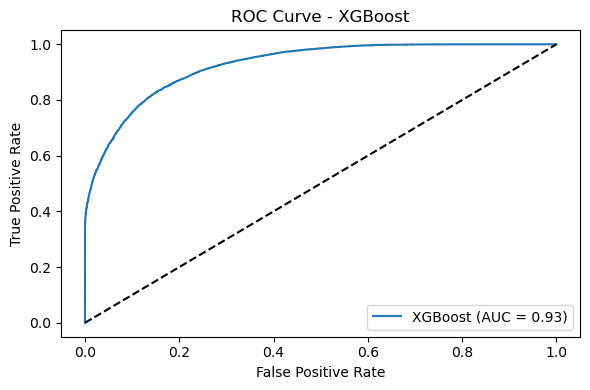

Confusion Matrix:
[[20056  2368]
 [ 3112 10134]]


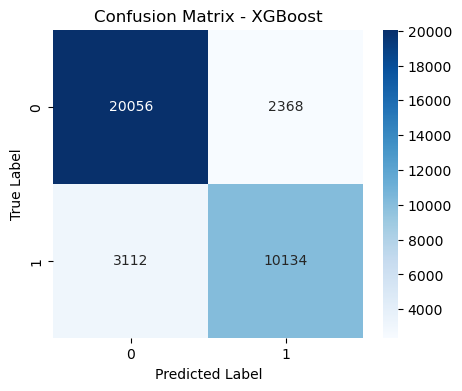

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix

# ROC Curve for XGBoost
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

plt.figure(figsize=(6, 4))
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_xgb:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# Confusion matrix for XGBoost
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))

cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(5, 4))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - XGBoost")
plt.show()

## 5.3 Display Feature Importances of XGboost

Top 15 most important features in XGBoost:
                          Feature  Importance
14        deposit_type_Non Refund    0.546754
21       market_segment_Online TA    0.058639
9     required_car_parking_spaces    0.057929
156                   country_PRT    0.036888
8       total_of_special_requests    0.013407
18          market_segment_Direct    0.012408
102                   country_ITA    0.010406
200          reserved_room_type_D    0.010165
209          assigned_room_type_D    0.008593
210          assigned_room_type_E    0.008301
64                    country_DEU    0.007724
199          reserved_room_type_C    0.007707
4                 booking_changes    0.007577
20   market_segment_Offline TA/TO    0.007554
52                    country_CHN    0.007315


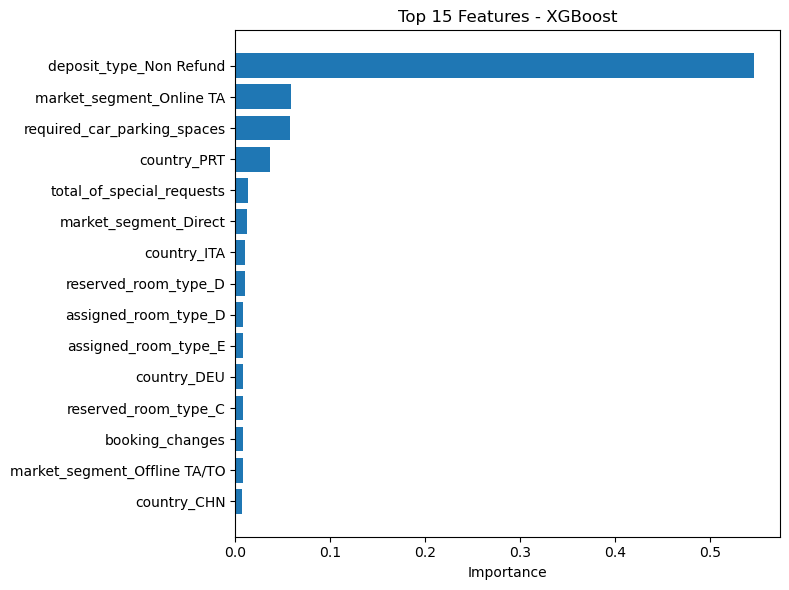

In [18]:
import matplotlib.pyplot as plt

# Get feature importances from trained XGBoost model
xgb_feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb_clf.feature_importances_
})
xgb_feature_importance = xgb_feature_importance.sort_values(by='Importance', ascending=False)

# Show the top 15 features
print("Top 15 most important features in XGBoost:")
print(xgb_feature_importance.head(15))

# Bar plot of the top 15 features
plt.figure(figsize=(8, 6))
plt.barh(
    xgb_feature_importance['Feature'].head(15),
    xgb_feature_importance['Importance'].head(15)
)
plt.xlabel('Importance')
plt.title('Top 15 Features - XGBoost')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

